# Deeplearning - Nasir Husain - 2021/08/14

# 8 Introduction to deep learning for computer vision

## 8.3 Leveraging a pretrained model

- using a pretrained model
  - effective approach
  - learning on small image datasets
- pretrained model
  - previously trained on a large dataset
  - typically on a large scale image-classification task. 
  - If original dataset is 
    - large enough and general enough
  - spatial hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world
  - features can prove useful for many different computer vision problems
- two ways to use a pretrained model
  - feature extraction
  - fine-tuning. 

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# # se this piece of code to download kaggle data directly to colab
# upload kaggle json file on the colab
from google.colab import files
files.upload()
# make kaggle directory
!mkdir ~/.kaggle
# move kaggle file to newly created folder
!cp kaggle.json ~/.kaggle/
# chnage permissions for file created
!chmod 600 ~/.kaggle/kaggle.json
# Downlaod data from kaggle
!kaggle competitions download -c dogs-vs-cats

# unzip downloaded data
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

# Copying images to training, validation, and test directories
# imports
import os, shutil, pathlib
# path to complete data set 
original_dir = pathlib.Path("train")
# path to smaller data set
new_base_dir = pathlib.Path("cats_vs_dogs_small")
# function to get images from complete set and save in subset
def make_subset(subset_name, start_index, end_index):
  # loop over cat and dog category
  for category in ("cat", "dog"):
    # path to new directory
    dir = new_base_dir / subset_name / category
    # make new directories
    os.makedirs(dir)
    # range of files names
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      # copy files from source to target
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)
# call sfor train, validation and test set
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# Using image_dataset_from_directory to read images
  # image_dataset_from_directory(directory) will list the subdirectories of directory
  # index the image files in each subdirectory
  # create and return a tf.data.Dataset object 
    # configured to read these files, 
    # shuffle them
    # decode them to tensors
    # resize them to a shared size
    # and pack them into batches.

from tensorflow.keras.utils import image_dataset_from_directory
 
# create datasets
train_dataset = image_dataset_from_directory(
    # path of the directory
    new_base_dir / "train",
    # reshape images to said size
    image_size=(180, 180),
    # batch size / 32 samples per batch
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

# Displaying the shapes of the data and labels yielded by the Dataset
for i, element in enumerate(train_dataset):
  pass
print("bathces of train_dataset : ",i)
for train_data_batch, train_labels_batch in train_dataset:
  print("train data batch shape:", train_data_batch.shape)
  print("train labels batch shape:", train_labels_batch.shape)
  break
for i, element in enumerate(validation_dataset):
  pass
print("bathces of validation_dataset : ",i)
for validation_data_batch, validation_labels_batch in validation_dataset:
  print("validation data batch shape:", validation_data_batch.shape)
  print("validation labels batch shape:", validation_labels_batch.shape)
  break
for i, element in enumerate(test_dataset):
  pass
print("bathces of test_dataset : ",i)
for test_data_batch, test_labels_batch in test_dataset:
  print("test data batch shape:", test_data_batch.shape)
  print("test labels batch shape:", test_labels_batch.shape)
  break

Mounted at /content/drive


Saving kaggle.json to kaggle.json
 99% 806M/812M [00:03<00:00, 211MB/s]
100% 812M/812M [00:03<00:00, 246MB/s]
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
bathces of train_dataset :  62
train data batch shape: (32, 180, 180, 3)
train labels batch shape: (32,)
bathces of validation_dataset :  31
validation data batch shape: (32, 180, 180, 3)
validation labels batch shape: (32,)
bathces of test_dataset :  62
test data batch shape: (32, 180, 180, 3)
test labels batch shape: (32,)


### 8.3.1 Feature extraction with a pretrained model

- Feature extraction
  - use the representations learned by a previously trained model to extract interesting features from new samples. 
  - These features are then run through a new classifier, which is trained from scratch.
- convnets used for image classification comprise two parts
  - they start with a series of pooling and convolution layers
  - they end with a densely connected classifier.
- The first part is called the convolutional base of the model.
- In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output

![FIG](./snaps/8.5.PNG)

- Why only reuse the convolutional base? 
- Could we reuse the densely connected classifier as well? 
  - representations learned by the convolutional base are likely to be more generic and, therefore, more reusable
  - the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained
  - representations found in densely connected layers no longer contain any information about where objects are located in the input image
- level of generality of the representations extracted by specific convolution layers depends on the depth of the layer in the model.
  - Layers that come earlier in the model extract local, highly generic feature maps
  - layers that are higher up extract more-abstract concepts

- image-classification models in keras
  - VGG16
  - Xception
  - ResNet
  - MobileNet
  - EfficientNet
  - DenseNet

In [2]:
from tensorflow import keras 

# Listing 8.19 Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    # weights specifies the weight checkpoint from which to initialize the model.
    weights="imagenet",
    # include_top refers to including (or not) the densely connected classifier on top of the network
      # By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet.
      # Because we intend to use our own densely connected classifier, 
      # we don’t need to include it.
    include_top=False,
    # input_shape is the shape of the image tensors that
      # we’ll feed to the network. This argument is purely optional: 
      # if we don’t pass it, the network will be able to process inputs of any size. 
      # Here we pass it so that we can visualize (in the following summary) 
      # how the size of the feature maps shrinks with each new convolution and pooling layer.
    input_shape=(180, 180, 3))


58900480/58889256 [==============================] - 0s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

- two ways we could proceed:
  - Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier similar to those you saw in chapter 4 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation.
  - Extend the model we have ( conv_base ) by adding Dense layers on top, and run the whole thing from end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.


#### FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION


In [4]:
# Listing 8.20 Extracting the VGG16 features and corresponding labels
import numpy as np
 
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)
 
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)
print("train features Shape :",train_features.shape)
print("train labels Shape :",train_labels.shape)
print("val features Shape :",val_features.shape)
print("val labels Shape :",val_labels.shape)
print("test features Shape :",test_features.shape)
print("test labels Shape :",test_labels.shape)


train features Shape : (2000, 5, 5, 512)
train labels Shape : (2000,)
val features Shape : (1000, 5, 5, 512)
val labels Shape : (1000,)
test features Shape : (2000, 5, 5, 512)
test labels Shape : (2000,)


In [5]:
from tensorflow.keras import layers

# Listing 8.21 Defining and training the densely connected classifier
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])
 
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="cats_vs_dogs_small_feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


Epoch 1/20
63/63 [==============================] - 3s 14ms/step - loss: 19.2520 - accuracy: 0.9195 - val_loss: 4.6606 - val_accuracy: 0.9720
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 3.9853 - accuracy: 0.9785 - val_loss: 4.4744 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2.0467 - accuracy: 0.9860 - val_loss: 5.7875 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.7224 - accuracy: 0.9865 - val_loss: 5.8630 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 1s 12ms/step - loss: 1.1257 - accuracy: 0.9920 - val_loss: 6.6407 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 1s 15ms/step - loss: 0.4922 - accuracy: 0.9955 - val_loss: 8.4395 - val_accuracy: 0.9630
Epoch 7/20
63/63 [==============================] - 1s 12ms/step - loss: 0.4947 - accuracy: 0.9960 - val_loss: 7.2955 - val_accuracy: 0.9680
Epoch 8/20
63

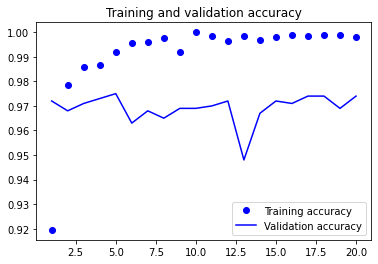

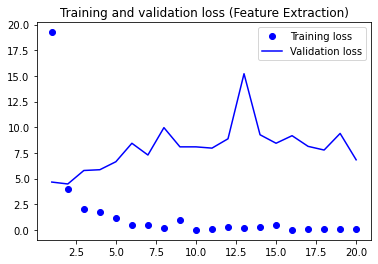

In [6]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy (Feature Extraction)")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss (Feature Extraction)")
plt.legend()
plt.show()

In [7]:
# Listing 8.26 Evaluating the model on the test set
test_model = keras.models.load_model("cats_vs_dogs_small_feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 4ms/step - loss: 5.2588 - accuracy: 0.9710
Test accuracy: 0.971


#### FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION
- model that chains the conv_base with a new dense classifier, and training it end to end on the inputs
-  first freeze the convolutional base
  - preventing their weights from being updated during training
  - if we dont the representations that were previously learned by the convolutional base will be modified during training

In [8]:
# Listing 8.23 Instantiating and freezing the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [9]:
# Listing 8.24 Printing the list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


# create a new model that chains together
  1. A data augmentation stage
  2. Our frozen convolutional base
  3. A dense classifier

In [10]:
# Listing 8.25 Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
    ]
)
 
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="cats_vs_dogs_small_feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 29s 434ms/step - loss: 16.9210 - accuracy: 0.9005 - val_loss: 8.2322 - val_accuracy: 0.9560
Epoch 2/50
63/63 [==============================] - 27s 427ms/step - loss: 7.9746 - accuracy: 0.9410 - val_loss: 3.9438 - val_accuracy: 0.9740
Epoch 3/50
63/63 [==============================] - 27s 428ms/step - loss: 5.9098 - accuracy: 0.9570 - val_loss: 4.8023 - val_accuracy: 0.9760
Epoch 4/50
63/63 [==============================] - 27s 427ms/step - loss: 5.5120 - accuracy: 0.9595 - val_loss: 3.2127 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 27s 425ms/step - loss: 4.7016 - accuracy: 0.9635 - val_loss: 8.7847 - val_accuracy: 0.9590
Epoch 6/50
63/63 [==============================] - 27s 426ms/step - loss: 4.1559 - accuracy: 0.9670 - val_loss: 5.9852 - val_accuracy: 0.9730
Epoch 7/50
63/63 [==============================] - 27s 430ms/step - loss: 3.8907 - accuracy: 0.9690 - val_loss: 7.6060 - val_accuracy: 0.963

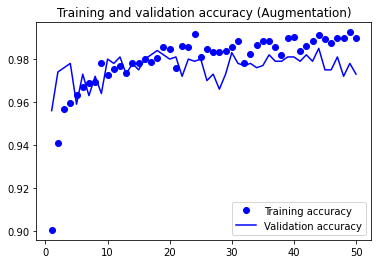

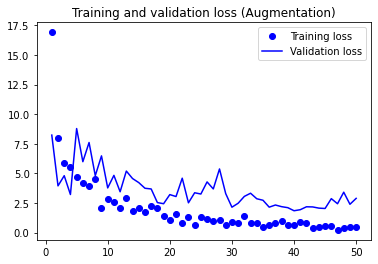

In [12]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy (Augmentation)")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss (Augmentation)")
plt.legend()
plt.show()

In [13]:
# Listing 8.26 Evaluating the model on the test set
test_model = keras.models.load_model("cats_vs_dogs_small_feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 18s 270ms/step - loss: 2.6372 - accuracy: 0.9735
Test accuracy: 0.974


### 8.3.2 Fine-tuning a pretrained model

- Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top layers. 
- This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused in order to make them more relevant for the problem at hand.
- steps for finetuning a network
  1. Add our custom network on top of an already trained base network.
  2. Freeze the base network.
  3. Train the part we added.
  4. Unfreeze some layers in the base network.
  5. Jointly train both these layers and the part we added.


- use the case from feature extraction without data augmentation part
  1. Add our custom network on top of an already trained base network.
  2. Freeze the base network.
  3. Train the part we added.

In [14]:
# This is same as above step
# Thus not executed again
# # base network
# conv_base = keras.applications.vgg16.VGG16(
#     weights="imagenet",
#     include_top=False)
# conv_base.trainable = False

# data_augmentation = keras.Sequential(
#     [
#      layers.RandomFlip("horizontal"),
#      layers.RandomRotation(0.1),
#      layers.RandomZoom(0.2),
#     ]
# )
 
# # model defination
# inputs = keras.Input(shape=(180, 180, 3))
# x = data_augmentation(inputs)
# x = keras.applications.vgg16.preprocess_input(x)
# x = conv_base(x)
# x = layers.Flatten()(x)
# x = layers.Dense(256)(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model = keras.Model(inputs, outputs)

# model.compile(
#     loss="binary_crossentropy",
#     optimizer="rmsprop",
#     metrics=["accuracy"])

# # train model
# history = model.fit(
#     train_dataset,
#     epochs=50,
#     validation_data=validation_dataset)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

- Why not fine-tune more layers?
- Why not fine-tune the entire convolutional base?
    - Earlier layers in the convolutional base encode more generic, reusable features, whereas layers higher up encode more specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
    - The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset.

In [15]:
# Listing 8.27 Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

- The reason for using a low learning rate is that we want to limit the magnitude of the modi-fications we make to the representations of the three layers we’re fine-tuning. 

In [16]:
# Listing 8.28 Fine-tuning the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])
 
callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath="cats_vs_dogs_small_feature_extraction_with_data_augmentation_fine_tuning.keras",
  save_best_only=True,
  monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 33s 472ms/step - loss: 0.4470 - accuracy: 0.9905 - val_loss: 3.2648 - val_accuracy: 0.9710
Epoch 2/30
63/63 [==============================] - 30s 467ms/step - loss: 0.3163 - accuracy: 0.9905 - val_loss: 2.6040 - val_accuracy: 0.9750
Epoch 3/30
63/63 [==============================] - 30s 466ms/step - loss: 0.4794 - accuracy: 0.9915 - val_loss: 2.4522 - val_accuracy: 0.9830
Epoch 4/30
63/63 [==============================] - 29s 462ms/step - loss: 0.2036 - accuracy: 0.9945 - val_loss: 2.9564 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 29s 461ms/step - loss: 0.3838 - accuracy: 0.9895 - val_loss: 2.5443 - val_accuracy: 0.9740
Epoch 6/30
63/63 [==============================] - 30s 467ms/step - loss: 0.2021 - accuracy: 0.9950 - val_loss: 2.1776 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 30s 467ms/step - loss: 0.3874 - accuracy: 0.9900 - val_loss: 1.9437 - val_accuracy: 0.9850

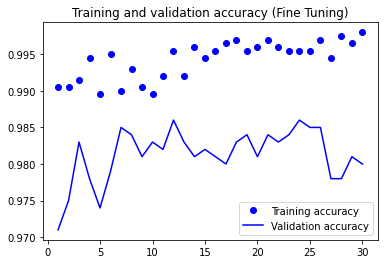

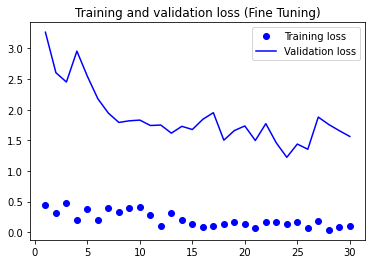

In [17]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy (Fine Tuning)")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss (Fine Tuning)")
plt.legend()
plt.show()

In [18]:
# Evaluating the model on the test set
test_model = keras.models.load_model("cats_vs_dogs_small_feature_extraction_with_data_augmentation_fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 18s 269ms/step - loss: 1.6005 - accuracy: 0.9775
Test accuracy: 0.978
